In [43]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from operator import itemgetter
from tqdm.notebook import tqdm
tqdm().pandas()


In [44]:
temp = pd.read_csv("/h/224/stevenhl/chess_dim_skill/src/word2vecf/vectors/size_alpha/vecs_0.16_265.txt", sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
problem_id = list(temp[0])
temp = temp.drop(0, axis = 1)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [75]:
sample_size = 1000
np.random.seed(51)
sampled_problems = np.random.choice(problem_id, size = sample_size, replace = False)
sampled_problems_temp = np.random.choice(problem_id, size = sample_size, replace = False)
sampled_problems = list(sampled_problems)
sampled_problems_temp = list(sampled_problems)

In [76]:
def embedding_list(sampled_problems):
    for i in range(len(sampled_problems)):
        pos = problem_id.index(sampled_problems[i])
        embedding = list(temp.iloc[pos,:])
        sampled_problems[i] = embedding
    return sampled_problems

In [77]:
cos_sim = sklearn.metrics.pairwise.cosine_similarity(embedding_list(sampled_problems))
cos_dist = 1 - cos_sim

In [78]:
cluster = AgglomerativeClustering(n_clusters = 20, affinity='precomputed', linkage='complete')
res = cluster.fit(cos_dist)
labels = list(res.labels_)
prob_pair = list(zip(sampled_problems_temp, labels))
prob_pair_sorted = sorted(prob_pair, key=itemgetter(1))

In [79]:
problem_id_grouped = [x[0] for x in prob_pair_sorted]
cos_sim_grouped = sklearn.metrics.pairwise.cosine_similarity(embedding_list(problem_id_grouped))

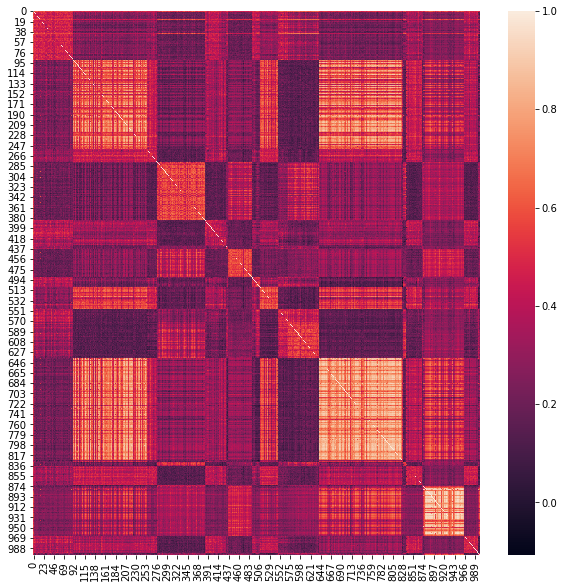

In [80]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
#sb.heatmap(cos_sim_grouped, xticklabels = problem_id_grouped, yticklabels = problem_id_grouped)
sb.heatmap(cos_sim_grouped)

(array([1.16000e+02, 2.73200e+03, 1.62440e+04, 2.12980e+04, 1.53194e+05,
        5.15502e+05, 2.87984e+05, 1.82400e+03, 7.80000e+01, 1.02800e+03]),
 array([-0.06130919,  0.04482173,  0.15095265,  0.25708356,  0.36321448,
         0.4693454 ,  0.57547632,  0.68160724,  0.78773816,  0.89386908,
         1.        ]),
 <a list of 10 Patch objects>)

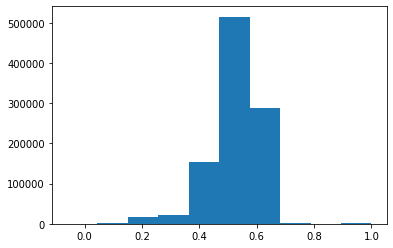

In [190]:
cos_sim_flatten = [item for sublist in cos_sim_grouped for item in sublist]
plt.hist(cos_sim_flatten, 10)